In [1]:
#%load_ext snakeviz
%matplotlib inline

In [1]:
#librerias utilitarias
from random import randint
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#librerias Keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D, AveragePooling2D
from keras.optimizers import SGD, Adadelta, Adagrad
from keras.utils import np_utils

Using TensorFlow backend.


In [4]:
from utils.multi_gpu import make_parallel

In [5]:
!nvidia-smi

Fri Jun 16 01:56:50 2017       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 375.39                 Driver Version: 375.39                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 0000:00:17.0     Off |                    0 |
| N/A   62C    P0    62W / 149W |      0MiB / 11439MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla K80           Off  | 0000:00:18.0     Off |                    0 |
| N/A   50C    P0    74W / 149W |      0MiB / 11439MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

### Cargar Datos
___

In [3]:
train_data = sio.loadmat('data/train_32x32.mat')
test_data = sio.loadmat('data/test_32x32.mat')
X_train = train_data['X'].T
y_train = train_data['y'] - 1
X_test = test_data['X'].T
y_test = test_data['y'] - 1
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
n_classes = len(np.unique(y_train))
#print (np.unique(y_train))
X_train /= 255
X_test /= 255
Y_train = np_utils.to_categorical(y_train, n_classes)
Y_test = np_utils.to_categorical(y_test, n_classes)
print (X_train.shape)
print (X_test.shape)
print (Y_train.shape)
print (Y_test.shape)

(73257, 3, 32, 32)
(26032, 3, 32, 32)
(73257, 10)
(26032, 10)


In [4]:
Y_test_parallel =np.delete(Y_test, 1, 0)
X_test_parallel =np.delete(X_test, 1, 0)
Y_train_parallel =np.delete(Y_train, 1, 0)
X_train_parallel =np.delete(X_train, 1, 0)
print (X_train_parallel.shape)
print (X_test_parallel.shape)
print (Y_train_parallel.shape)
print (Y_test_parallel.shape)

(73256, 3, 32, 32)
(26031, 3, 32, 32)
(73256, 10)
(26031, 10)


Objetivo
-----
**(C)** Defina una CNN con arquitectura **C × P × C × P × F × F **. Para la primera capa convolucional utilice 16 filtros de 5×5 y para la segunda 512 filtros de 7×7. Para la capa MLP escondida use 20 neuronas. Esta arquitectura, con algunas diferencias, fue una de las primera CNNs entrenadas sobre SVHN y **consiguio una accuracy de 94.28%** [11]. Genere un esquema lo mas compacto posible que muestre los cambios de forma que experimenta un patrón de entrada a medida que se ejecuta un forward-pass. Entrene la red anterior un máximo de 10 epochs. **¿Logra mejorar o al menos igualar el resultado reportado en la literatura?**

In [5]:
#Parametros
_size, n_channels, n_rows, n_cols = X_train_parallel.shape

El modelo solictado tendra la siguente caractericias:

In [6]:
model = Sequential()

#Capa convolucional utiliza 16 filtros de dimensiones 5 x 5, no-linealidad ReLU
model.add(Convolution2D(16, (5, 5), padding='same', activation='relu', input_shape=(n_channels, n_rows, n_cols)))

#Capa de pooling, reducción de dimencionalidad sen un factor de 2.
model.add(MaxPooling2D(pool_size=(2, 2)))

#Capa convolucional utiliza 512 filtros de dimensiones 7 x 7, no-linealidad ReLU
model.add(Convolution2D(512, (7, 7), padding='same', activation='relu'))

# Capa de pooling, reducción de dimencionalidad sen un factor de 2.
model.add(MaxPooling2D(pool_size=(2, 2)))

#capa de tipo flatten para la vectorización de las características.
model.add(Flatten())

#capa densa (full conectada)
model.add(Dense(20, activation='relu'))

#La capa de salida con función de activación softmax. (posee 10 neuronas = 10 categorias)
model.add(Dense(n_classes, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 16, 32, 32)        1216      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 512, 16, 16)       401920    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 512, 8, 8)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                655380    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                210       
Total para

![title](model.png)

**Nota:**
    El modelo podemos visualizar la esencia del las redes convolucionales que es el paso o reducción de dimencionalidad o especialización de las capas en features de mayor alto a nivel a otras de mayor precisión. Todo lo anterior antes de llegar a las capas full-connected donde la operación flatten termina con multidimencionalidad del problema, pasando a una representación vectorial del problema, y a su procesamiento en redes tradicionales.


In [10]:
opt = Adagrad(lr=0.01, epsilon=1e-08, decay=0.0)

Con el paso que viene a continuación, logramos que todas las operaciones sobre el modelo pasen de ejecutarse en una GPU, a un esquema paralelo multi-GPU. Esto se verá reflejado en los tiempos de fit, registrados en los notebook.  

In [11]:
model = make_parallel(model, 8)

/home/ubuntu/Tarea/parte2/utils/multi_gpu.py:44: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  merged.append(merge(outputs, mode='concat', concat_axis=0))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/keras/legacy/layers.py:460: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
/home/ubuntu/Tarea/parte2/utils/multi_gpu.py:46: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`
  return Model(input=model.inputs, output=merged)


In [13]:
epochs = 10
#batch_size= 32
batch_size=1280

De acuerdo a lo indicado en clases se usará en todos los modelos, salvo en los que tengamos que comparar funciones de perdia, **categorical crossentropy**. Lo anterior porque a diferencia de por ejemplo binary crossentropy, en este problema **esperamos salidas mutuamente excluyentes por cada categoría.**

In [12]:
%%time
model.compile(loss='categorical_crossentropy', optimizer=opt,  metrics=['accuracy'])

CPU times: user 19.2 ms, sys: 3.94 ms, total: 23.1 ms
Wall time: 22.2 ms


In [14]:
%%time
history_categorical_crossentropy = model.fit(X_train_parallel, Y_train_parallel, batch_size=batch_size, epochs=epochs, verbose=0,
          validation_data=(X_test, Y_test))

CPU times: user 6min 27s, sys: 2min 30s, total: 8min 57s
Wall time: 2min 5s


Usaremos mean_squared_error para validar la elección de categorical crossentropy

In [16]:
model.compile(loss='mean_squared_error', optimizer=opt,  metrics=['accuracy'])

In [17]:
%%time
history_mean_squared_error = model.fit(X_train_parallel, Y_train_parallel, batch_size=batch_size, epochs=epochs, verbose=0,
          validation_data=(X_test, Y_test))

CPU times: user 6min 23s, sys: 2min 24s, total: 8min 48s
Wall time: 1min 50s


### Comentarios
---

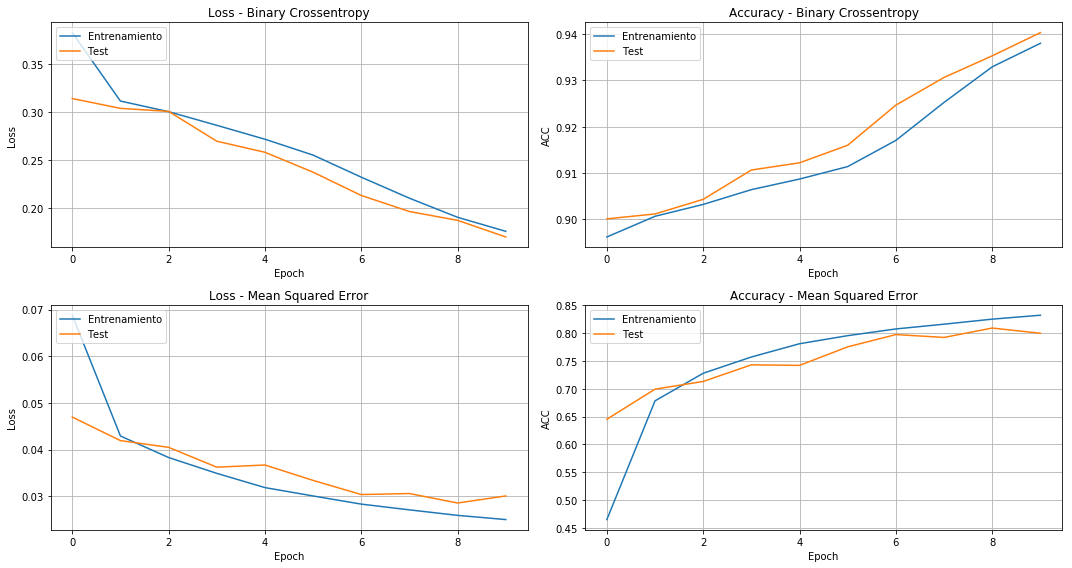

In [19]:
plt.figure(figsize=(15, 8))
plt.subplot(2, 2, 1)
plt.plot(history_categorical_crossentropy.history['loss'])  
plt.plot(history_categorical_crossentropy.history['val_loss'])  
plt.title('Loss - Binary Crossentropy')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['Entrenamiento', 'Test'], loc='upper left')  
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(history_categorical_crossentropy.history['acc'])  
plt.plot(history_categorical_crossentropy.history['val_acc'])  
plt.title('Accuracy - Binary Crossentropy')  
plt.ylabel('ACC')  
plt.xlabel('Epoch')  
plt.legend(['Entrenamiento', 'Test'], loc='upper left')
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(history_mean_squared_error.history['loss'])  
plt.plot(history_mean_squared_error.history['val_loss'])  
plt.title('Loss - Mean Squared Error')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['Entrenamiento', 'Test'], loc='upper left')
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(history_mean_squared_error.history['acc'])  
plt.plot(history_mean_squared_error.history['val_acc'])  
plt.title('Accuracy - Mean Squared Error')  
plt.ylabel('ACC')  
plt.xlabel('Epoch')  
plt.legend(['Entrenamiento', 'Test'], loc='upper left')
plt.grid(True)

plt.tight_layout()
plt.show()

### Comentarios
---

Como podemos ver el uso de  categorical crossentropy presenta mejores resultados tanto en el accuracy, pues tiene un performance de 94.04% versus el 79.98% De Mean Squared Error. Además la curva de aprendizaje presenta un comportamiento mas estable, sin grandes saltos.

In [18]:
#%%time
scores = model.evaluate(X_test, Y_test)
print("")
print("Accuracy del modelo con Mean Squared Error: %.2f%%" % (scores[1]*100))
print("Loss del modelo con Mean Squared Error: %.2f%%" % (scores[0]*100))

25952/26032 [============================>.] - ETA: 0s 

In [15]:
#%%time
scores = model.evaluate(X_test, Y_test)
print("")
print("Accuracy del modelo con Binary Crossentropy : %.2f%%" % (scores[1]*100))
print("Loss del modelo con Binary Crossentropy: %.2f%%" % (scores[0]*100))

25952/26032 [============================>.] - ETA: 0s 